In [1]:
%matplotlib inline

In [100]:
import numpy as np
from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV, learning_curve, validation_curve

In [3]:
df = pd.read_csv("~/projects/us-education-datasets-unification-project/data/us-education-datasets-unification-project/states_all.csv")

In [4]:
df.shape

(1492, 25)

In [5]:
np.sqrt(df.shape[0])
df.shape[0]/50

29.84

In [6]:
df.head(5)

PRIMARY_KEY       STATE  YEAR  ENROLL  TOTAL_REVENUE  FEDERAL_REVENUE  \
0     1992_ALABAMA     ALABAMA  1992     NaN      2678885.0         304177.0   
1      1992_ALASKA      ALASKA  1992     NaN      1049591.0         106780.0   
2     1992_ARIZONA     ARIZONA  1992     NaN      3258079.0         297888.0   
3    1992_ARKANSAS    ARKANSAS  1992     NaN      1711959.0         178571.0   
4  1992_CALIFORNIA  CALIFORNIA  1992     NaN     26260025.0        2072470.0   

   STATE_REVENUE  LOCAL_REVENUE  TOTAL_EXPENDITURE  INSTRUCTION_EXPENDITURE  \
0      1659028.0       715680.0          2653798.0                1481703.0   
1       720711.0       222100.0           972488.0                 498362.0   
2      1369815.0      1590376.0          3401580.0                1435908.0   
3       958785.0       574603.0          1743022.0                 964323.0   
4     16546514.0      7641041.0         27138832.0               14358922.0   

   ...  GRADES_4_G  GRADES_8_G  GRADES_12_G  GRADES_1_8_G  GRADES_9_12_G  \
0  ...     57948.0     58025.0      41167.0      471564.0       196386.0   
1  ...      9748.0      8789.0       6714.0       79117.0        30847.0   
2  ...     55433.0     49081.0      37410.0      437127.0       175210.0   
3  ...     34632.0     36011.0      27651.0      281338.0       123113.0   
4  ...    418418.0    363296.0     270675.0     3286034.0      1372011.0   

   GRADES_ALL_G  AVG_MATH_4_SCORE  AVG_MATH_8_SCORE  AVG_READING_4_SCORE  \
0      676174.0        208.327876        252.187522           207.963517   
1      112335.0               NaN               NaN                  NaN   
2      614881.0        215.253932        265.366278           206.212716   
3      405259.0        210.206028        256.312090           208.634458   
4     4717112.0        208.398961        260.892247           196.764414   

   AVG_READING_8_SCORE  
0                  NaN  
1           258.859712  
2           262.169895  
3           264.619665  
4                  NaN  

[5 rows x 25 columns]

In [7]:
df.columns.tolist()

['PRIMARY_KEY',
 'STATE',
 'YEAR',
 'ENROLL',
 'TOTAL_REVENUE',
 'FEDERAL_REVENUE',
 'STATE_REVENUE',
 'LOCAL_REVENUE',
 'TOTAL_EXPENDITURE',
 'INSTRUCTION_EXPENDITURE',
 'SUPPORT_SERVICES_EXPENDITURE',
 'OTHER_EXPENDITURE',
 'CAPITAL_OUTLAY_EXPENDITURE',
 'GRADES_PK_G',
 'GRADES_KG_G',
 'GRADES_4_G',
 'GRADES_8_G',
 'GRADES_12_G',
 'GRADES_1_8_G',
 'GRADES_9_12_G',
 'GRADES_ALL_G',
 'AVG_MATH_4_SCORE',
 'AVG_MATH_8_SCORE',
 'AVG_READING_4_SCORE',
 'AVG_READING_8_SCORE']

In [17]:
set(df[df['AVG_MATH_4_SCORE']>0]['YEAR'].subtract(1).tolist())

{1991, 1995, 1999, 2002, 2004, 2006, 2008, 2010, 2012, 2014, 2016}

In [18]:
df['avg_total_revenue']=df['TOTAL_REVENUE']/df['GRADES_ALL_G']
df['avg_total_expenditure'] = df['TOTAL_EXPENDITURE'] / df['GRADES_ALL_G']

df['fracn_schoolage'] = df['GRADES_ALL_G']/df['ENROLL']
df['rev_per_person'] = df['TOTAL_REVENUE'] / df['ENROLL']
df['exp_per_rev'] = df['TOTAL_EXPENDITURE'] / df['TOTAL_REVENUE']

In [19]:
#Normalize expenditures to fraction of total expenditures
expenditure_cols = ['INSTRUCTION_EXPENDITURE',
 'SUPPORT_SERVICES_EXPENDITURE',
 'OTHER_EXPENDITURE',
 'CAPITAL_OUTLAY_EXPENDITURE']

for col in expenditure_cols:
    df['fracn_exp_{}'.format(col)] = df[col] / df['TOTAL_EXPENDITURE']
    #df=df.drop(col, axis=1)
    print('fracn_exp_{}'.format(col))

fracn_exp_INSTRUCTION_EXPENDITURE
fracn_exp_SUPPORT_SERVICES_EXPENDITURE
fracn_exp_OTHER_EXPENDITURE
fracn_exp_CAPITAL_OUTLAY_EXPENDITURE


In [20]:
#Normalize revenue to fraction of total revenue
revenue_cols = ['FEDERAL_REVENUE',
 'STATE_REVENUE',
 'LOCAL_REVENUE']

for col in revenue_cols:
    df['fracn_rev_{}'.format(col)] = df[col] / df['TOTAL_REVENUE']
    #df=df.drop(col, axis=1)
    print('fracn_rev_{}'.format(col))

fracn_rev_FEDERAL_REVENUE
fracn_rev_STATE_REVENUE
fracn_rev_LOCAL_REVENUE


In [21]:
#Normalize students enrolled to fraction of enrolled population
fracn_enroll_cols = ['GRADES_PK_G', 'GRADES_KG_G',
       'GRADES_4_G', 'GRADES_8_G', 'GRADES_12_G', 'GRADES_1_8_G',
       'GRADES_9_12_G']

for col in fracn_enroll_cols:
    df['fracn_enroll_{}'.format(col)] = df[col] / df['GRADES_ALL_G']
    print('fracn_enroll_{}'.format(col))
    #df = df.drop(col, axis=1) 

fracn_enroll_GRADES_PK_G
fracn_enroll_GRADES_KG_G
fracn_enroll_GRADES_4_G
fracn_enroll_GRADES_8_G
fracn_enroll_GRADES_12_G
fracn_enroll_GRADES_1_8_G
fracn_enroll_GRADES_9_12_G


In [12]:
#sns.pairplot(df, kind='scatter')

/Users/daviderickson/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/daviderickson/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


(42, 42)


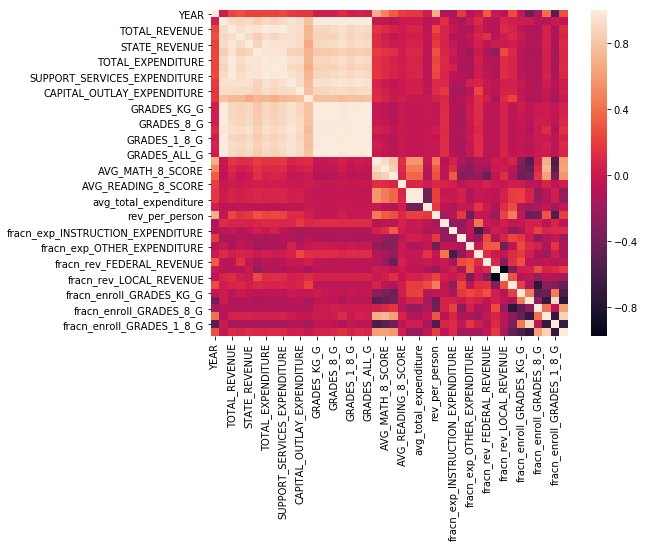

In [22]:
corr = df.corr()
print(corr.shape)
fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(corr)

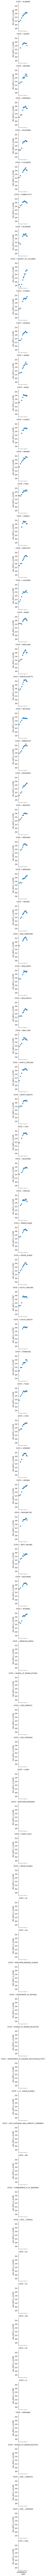

In [23]:
g = sns.FacetGrid(df, row="STATE") 
g.map(plt.scatter, 'YEAR', 'AVG_MATH_4_SCORE')

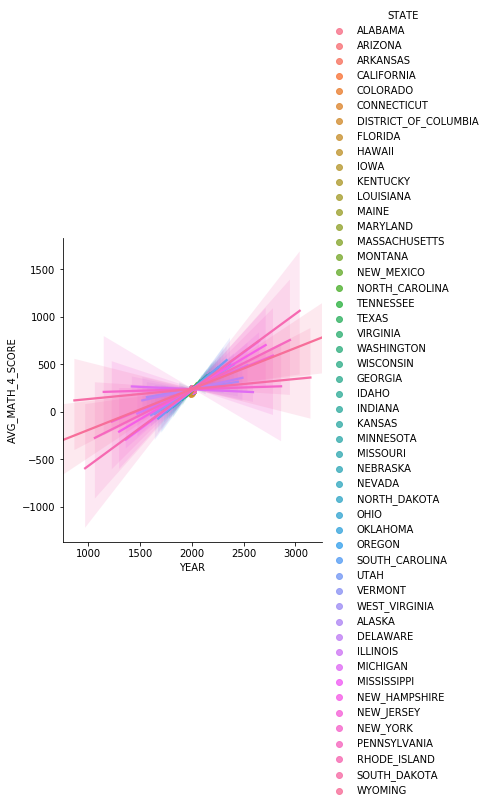

In [24]:
sns.lmplot(x="YEAR", y="AVG_MATH_4_SCORE", hue="STATE", data=df.dropna(), legend_out=True);

/Users/daviderickson/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/daviderickson/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


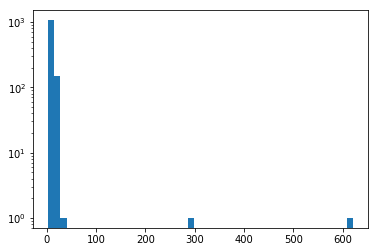

In [25]:
plt.hist('avg_total_expenditure', bins=50, log=True, data=df);

In [26]:
#For some reason VIRGINIA has 3 entries for 2008 and 2 of them have increicbly high avg_instruction_expenditure
df[df['avg_total_expenditure'] > 100]

PRIMARY_KEY     STATE  YEAR     ENROLL  TOTAL_REVENUE  FEDERAL_REVENUE  \
863  2008_VIRGINIA  VIRGINIA  2008  1230857.0     14768120.0         897627.0   
864  2008_VIRGINIA  VIRGINIA  2008  1230857.0     14768120.0         897627.0   

     STATE_REVENUE  LOCAL_REVENUE  TOTAL_EXPENDITURE  INSTRUCTION_EXPENDITURE  \
863      5957786.0      7912707.0         15236306.0                8003167.0   
864      5957786.0      7912707.0         15236306.0                8003167.0   

     ...  fracn_rev_FEDERAL_REVENUE  fracn_rev_STATE_REVENUE  \
863  ...                   0.060781                 0.403422   
864  ...                   0.060781                 0.403422   

     fracn_rev_LOCAL_REVENUE  fracn_enroll_GRADES_PK_G  \
863                 0.535796                  0.033129   
864                 0.535796                  0.104667   

     fracn_enroll_GRADES_KG_G  fracn_enroll_GRADES_4_G  \
863                  0.105619                 0.090875   
864                  0.140873                 0.103771   

     fracn_enroll_GRADES_8_G  fracn_enroll_GRADES_12_G  \
863                 0.075236                  0.049372   
864                 0.060479                  0.019712   

     fracn_enroll_GRADES_1_8_G  fracn_enroll_GRADES_9_12_G  
863                   0.716857                    0.250015  
864                   0.783009                    0.112324  

[2 rows x 44 columns]

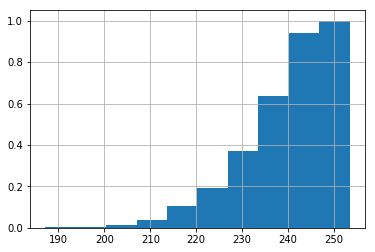

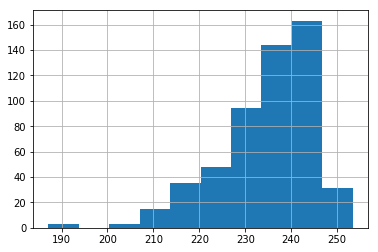

In [27]:
df['AVG_MATH_4_SCORE'].dropna().hist(density=True, cumulative=True)
plt.show()
df['AVG_MATH_4_SCORE'].dropna().hist()

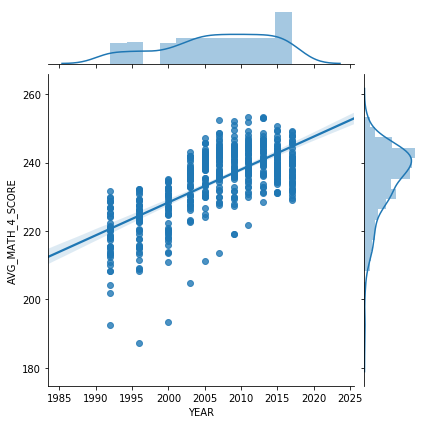

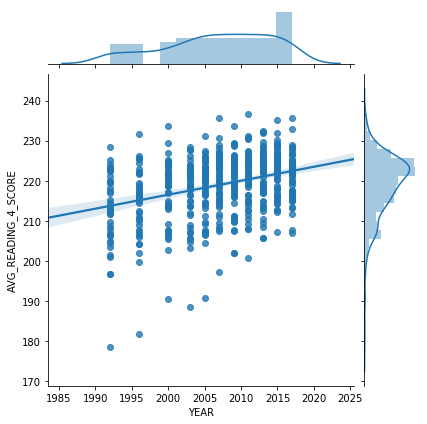

In [28]:
sns.jointplot("YEAR", "AVG_MATH_4_SCORE", data=df, kind="reg")
sns.jointplot("YEAR", "AVG_READING_4_SCORE", data=df, kind="reg")

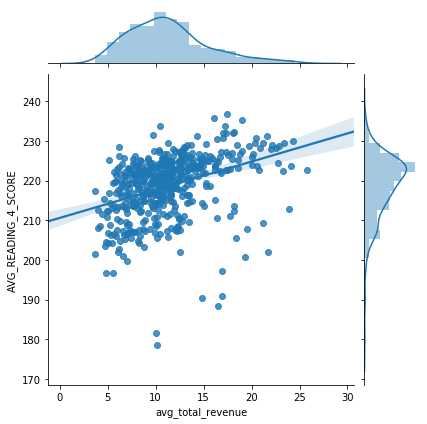

In [20]:
sns.jointplot("avg_total_revenue", "AVG_READING_4_SCORE", data=df, kind="reg")

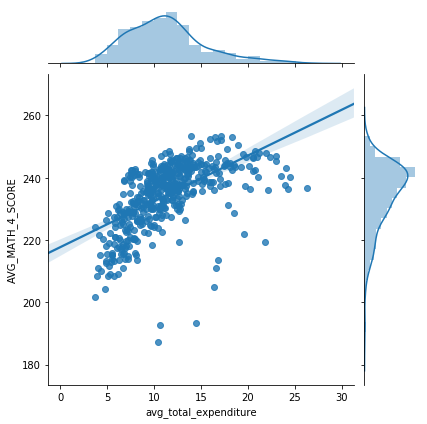

In [21]:
sns.jointplot("avg_total_expenditure", "AVG_MATH_4_SCORE", data=df, kind="reg")

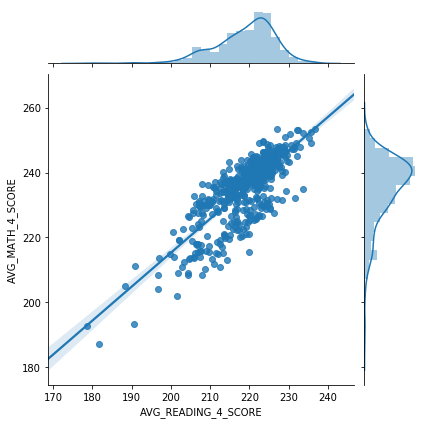

In [22]:
sns.jointplot("AVG_READING_4_SCORE", "AVG_MATH_4_SCORE", data=df, kind="reg")

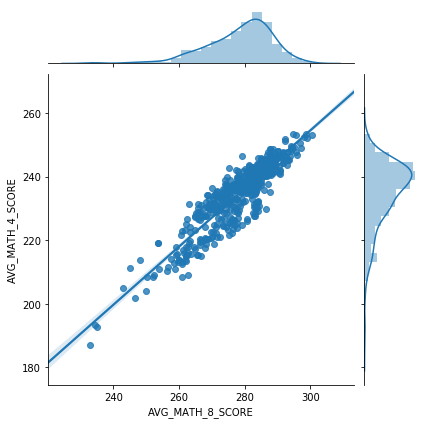

In [23]:
sns.jointplot("AVG_MATH_8_SCORE", "AVG_MATH_4_SCORE", data=df, kind="reg")

In [39]:
df1=df.drop(['PRIMARY_KEY','AVG_MATH_8_SCORE','AVG_READING_4_SCORE','AVG_READING_8_SCORE','ENROLL'],axis=1)
df1 = df1.dropna()
print(df1.columns)
df1 = pd.get_dummies(df1, columns=['STATE'])

y=df1.loc[:,'AVG_MATH_4_SCORE'].values
X=df1.drop(['AVG_MATH_4_SCORE'],axis=1).loc[:,:].values
X_cols=df1.drop(['AVG_MATH_4_SCORE'],axis=1).columns

ts_cv = TimeSeriesSplit(n_splits=5)
print(ts_cv)
for train_index, test_index in ts_cv.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

"""
PredefinedSplit won't work because it folds in future data

test_fold = df1.loc[:,'YEAR'].values
ps = PredefinedSplit(test_fold)
print(ps.get_n_splits())
for train_index, test_index in ps.split():
    print("Train:", train_index, "Test:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]    
"""

Index(['STATE', 'YEAR', 'TOTAL_REVENUE', 'FEDERAL_REVENUE', 'STATE_REVENUE',
       'LOCAL_REVENUE', 'TOTAL_EXPENDITURE', 'INSTRUCTION_EXPENDITURE',
       'SUPPORT_SERVICES_EXPENDITURE', 'OTHER_EXPENDITURE',
       'CAPITAL_OUTLAY_EXPENDITURE', 'GRADES_PK_G', 'GRADES_KG_G',
       'GRADES_4_G', 'GRADES_8_G', 'GRADES_12_G', 'GRADES_1_8_G',
       'GRADES_9_12_G', 'GRADES_ALL_G', 'AVG_MATH_4_SCORE',
       'avg_total_revenue', 'avg_total_expenditure', 'fracn_schoolage',
       'rev_per_person', 'exp_per_rev', 'fracn_exp_INSTRUCTION_EXPENDITURE',
       'fracn_exp_SUPPORT_SERVICES_EXPENDITURE', 'fracn_exp_OTHER_EXPENDITURE',
       'fracn_exp_CAPITAL_OUTLAY_EXPENDITURE', 'fracn_rev_FEDERAL_REVENUE',
       'fracn_rev_STATE_REVENUE', 'fracn_rev_LOCAL_REVENUE',
       'fracn_enroll_GRADES_PK_G', 'fracn_enroll_GRADES_KG_G',
       'fracn_enroll_GRADES_4_G', 'fracn_enroll_GRADES_8_G',
       'fracn_enroll_GRADES_12_G', 'fracn_enroll_GRADES_1_8_G',
       'fracn_enroll_GRADES_9_12_G'],
      

'\nPredefinedSplit won\'t work because it folds in future data\n\ntest_fold = df1.loc[:,\'YEAR\'].values\nps = PredefinedSplit(test_fold)\nprint(ps.get_n_splits())\nfor train_index, test_index in ps.split():\n    print("Train:", train_index, "Test:", test_index)\n    X_train, X_test = X[train_index], X[test_index]\n    y_train, y_test = y[train_index], y[test_index]    \n'

In [78]:
n_splits=20
ts_cv = TimeSeriesSplit(n_splits=n_splits)
rf_model = RandomForestRegressor(n_estimators=100, n_jobs=-1)

index=0
train_score = np.zeros(n_splits)
test_score = np.zeros(n_splits)

for train_index, test_index in ts_cv.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]   
    
    rf_model.fit(X_train, y_train) 
    Y_rf=rf_model.predict(X_test)
    train_score[index]=rf_model.score(X_train,y_train) #Train score
    test_score[index]=rf_model.score(X_test,y_test) #Test score
    index+=1
index_list=np.arange(index)

In [79]:
print(index)
print(index_list)
print(train_score)
print(test_score)

20
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]
[0.87743241 0.93721942 0.92766199 0.93698373 0.95198103 0.95342817
 0.96588772 0.96370031 0.9689944  0.96655296 0.97179889 0.96716622
 0.9741365  0.97599768 0.97665689 0.97586201 0.97509335 0.97640564
 0.97721774 0.97559188]
[ 0.70394337  0.35288045  0.09084826 -0.41063608  0.35851226  0.53464706
  0.0646454   0.68639907  0.55676388  0.48311745  0.68670486  0.62354969
  0.7118994   0.51936996  0.29169025  0.13279522  0.67505858  0.46321572
  0.73405799  0.57500936]


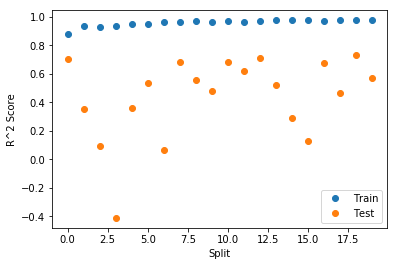

In [80]:
plt.plot(index_list,train_score,'o', label="Train")
plt.plot(index_list,test_score,'o', label="Test")
plt.xlabel("Split")
plt.ylabel("R^2 Score")
plt.legend(loc="best")

In [126]:
model=RandomForestRegressor()

num_splits=30
ts_cv=TimeSeriesSplit(n_splits=num_splits) #.split(X)

"""
param_search = [
  {'n_estimators': [1, 10, 20, 100]}
]
gsrch_rf_model=GridSearchCV(estimator=model, param_grid=param_search, cv=ts_cv, n_jobs=-1)
gsrch_rf_model.fit(X,y)
"""

#train_sizes, train_scores, test_scores = \
#    learning_curve(estimator=model, X=X, y=y, train_sizes=np.linspace(0.1,1.0,num=10), cv=ts_cv, n_jobs=-1)

param_range=[1,5,10,20,30,40,50,60]
train_scores_vc, test_scores_vc = \
    validation_curve(estimator=model, X=X, y=y, param_name="n_estimators", param_range=param_range, cv=ts_cv, n_jobs=-1)

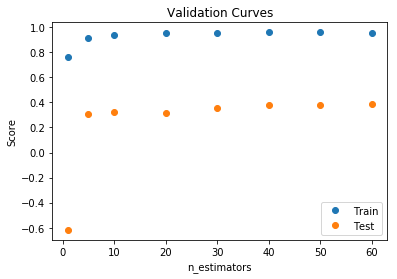

In [127]:
train_scores_mean = np.mean(train_scores_vc, axis=1)
train_scores_std = np.std(train_scores_vc, axis=1)
test_scores_mean = np.mean(test_scores_vc, axis=1)
test_scores_std = np.std(test_scores_vc, axis=1)

plt.figure()
plt.plot(param_range,train_scores_mean,'o',label="Train")
plt.plot(param_range,test_scores_mean,'o',label="Test")
plt.xlabel("n_estimators")
plt.ylabel("Score")
plt.title("Validation Curves")
plt.legend(loc="best")

In [124]:
model=RandomForestRegressor(n_estimators=20)

num_splits=30
ts_cv=TimeSeriesSplit(n_splits=num_splits) #.split(X)

train_sizes, train_scores, test_scores = \
    learning_curve(estimator=model, X=X, y=y, train_sizes=np.linspace(0.1,1.0,num=10), cv=ts_cv, n_jobs=-1)

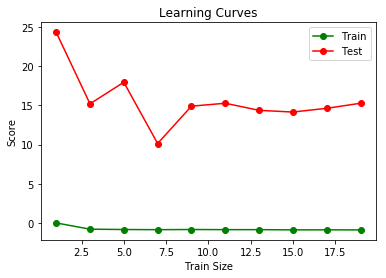

In [125]:
plt.figure()
plt.plot(train_sizes, -train_scores.mean(1), 'o-', color="g",
         label="Train")
plt.plot(train_sizes, -test_scores.mean(1), 'o-', color="r",
         label="Test")
plt.xlabel("Train Size")
plt.ylabel("Score")
plt.title("Learning Curves")
plt.legend(loc="best")

In [40]:
rf_model = RandomForestRegressor(n_estimators=100)
rf_model.fit(X, y)  

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

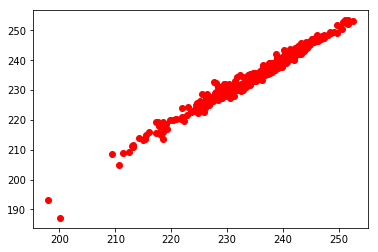

In [41]:
Y_rf=rf_model.predict(X)
plt.plot(Y_rf, y, 'ro')
plt.show()

In [42]:
rf_model.score(X,y)

0.9756092022965892

In [27]:
feature_importances_rf = pd.DataFrame(rf_model.feature_importances_, index = df1.drop(['AVG_MATH_4_SCORE'],axis=1).columns, columns=['importance']).sort_values('importance',ascending=False)
feature_importances_rf.head(10)

importance
YEAR                                      0.406031
fracn_enroll_GRADES_12_G                  0.203163
fracn_rev_FEDERAL_REVENUE                 0.052134
avg_total_revenue                         0.023097
fracn_exp_SUPPORT_SERVICES_EXPENDITURE    0.022794
avg_total_expenditure                     0.019637
rev_per_person                            0.017126
fracn_rev_LOCAL_REVENUE                   0.015487
fracn_enroll_GRADES_8_G                   0.013319
fracn_exp_OTHER_EXPENDITURE               0.012164

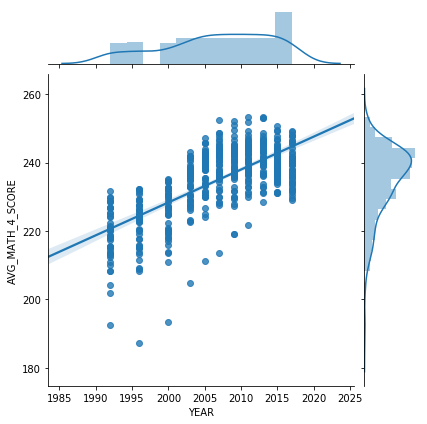

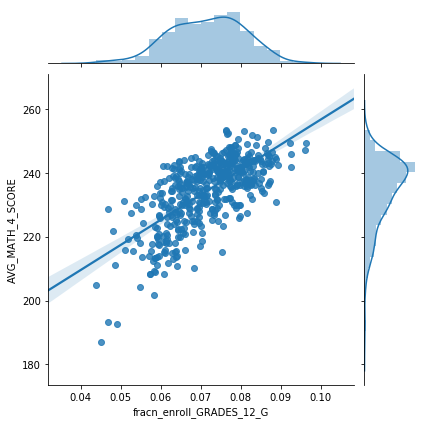

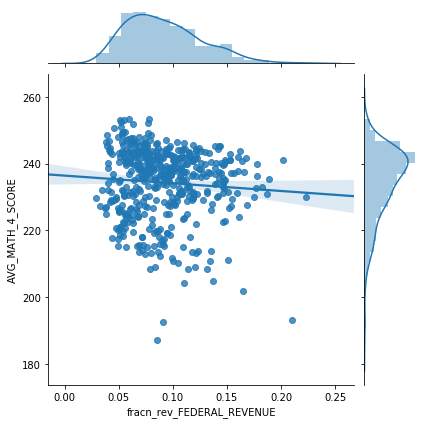

In [28]:
sns.jointplot(x='YEAR', y='AVG_MATH_4_SCORE', data=df, kind='reg')
sns.jointplot(x='fracn_enroll_GRADES_12_G', y='AVG_MATH_4_SCORE', data=df, kind='reg')
sns.jointplot(x='fracn_rev_FEDERAL_REVENUE', y='AVG_MATH_4_SCORE', data=df, kind='reg')

In [29]:
from sklearn import svm
svm_model = svm.SVR(gamma='scale')
svm_model.fit(X, y)  

SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='scale',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

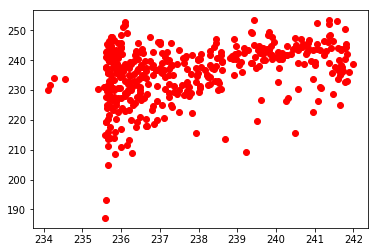

In [44]:
Y_svm=svm_model.predict(X)
plt.plot(Y_svm, y, 'ro')
plt.show()

In [128]:
from sklearn import linear_model
lasso_model = linear_model.Lasso(alpha=0.01, normalize=True)
lasso_model.fit(X, y)  
Y_lasso=lasso_model.predict(X)

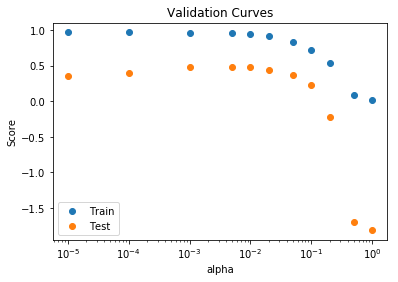

In [135]:
model=linear_model.Lasso(normalize=True)
param_search = [
  {'alpha': [0.00001,0.0001,0.001,0.01,0.1,1]}
 ]

num_splits=30
ts_cv=TimeSeriesSplit(n_splits=num_splits) #.split(X)

#gsrch_rf_model=GridSearchCV(estimator=model, param_grid=param_search, cv=ts_cv, n_jobs=-1)
#gsrch_rf_model.fit(X,y)

#train_sizes, train_scores, test_scores = \
#    learning_curve(estimator=model, X=X, y=y, train_sizes=np.linspace(0.1,1.0,num=10), cv=ts_cv, n_jobs=-1)

param_range=[0.00001,0.0001,0.001,0.005,0.01,0.02,0.05,0.1,0.2,0.5,1]
train_scores_vc, test_scores_vc = \
    validation_curve(estimator=model, X=X, y=y, param_name="alpha", param_range=param_range, cv=ts_cv, n_jobs=-1)

train_scores_mean = np.mean(train_scores_vc, axis=1)
train_scores_std = np.std(train_scores_vc, axis=1)
test_scores_mean = np.mean(test_scores_vc, axis=1)
test_scores_std = np.std(test_scores_vc, axis=1)

plt.figure()
plt.semilogx(param_range,train_scores_mean,'o',label="Train")
plt.semilogx(param_range,test_scores_mean,'o',label="Test")
plt.xlabel("alpha")
plt.ylabel("Score")
plt.title("Validation Curves")
plt.legend(loc="best")

Text(0, 0.5, 'y')

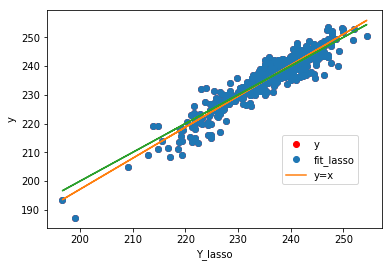

In [136]:
plt.plot(Y_lasso, y, 'ro')

# Generated linear fit
slope, intercept, r_value, p_value, std_err = stats.linregress(Y_lasso,y)
line = slope*Y_lasso+intercept

plt.plot(Y_lasso,y,'o',Y_lasso,line,Y_lasso,Y_lasso)
plt.legend(("y","fit_lasso","y=x"),loc=(0.7,0.2))
plt.xlabel("Y_lasso")
plt.ylabel("y")

In [94]:
lasso_coef_ = lasso_model.coef_
print(X_cols.shape)
#print(X_cols)
print(lasso_coef_.shape)
print(np.round(lasso_coef_))
#print(lasso_coef_)
X_cols[np.abs(lasso_coef_)>10]

(88,)
(88,)
[   1.   -0.   -0.   -0.   -0.   -0.   -0.   -0.   -0.    0.    0.   -0.
   -0.   -0.   -0.   -0.   -0.   -0.    0.    0.    0.    0.    0.   -0.
  -30.  -21.    6.   -0.   -0.    0.   -0.    0. -259.  109.  185.   -0.
   48.   -6.   -2.   -3.   -1.   -8.    2.    2.   -0.  -12.    0.   -0.
   -0.    0.   -1.    4.   -0.    3.   -0.   -2.    0.    0.    8.   -1.
    1.   -5.   -0.    0.   -1.   -1.    5.    4.   -7.   -2.    5.    0.
    2.    0.   -0.   -0.   -0.   -0.    0.   -2.    4.    0.    0.    3.
    0.   -2.    0.    2.]


Index(['fracn_exp_SUPPORT_SERVICES_EXPENDITURE', 'fracn_exp_OTHER_EXPENDITURE',
       'fracn_enroll_GRADES_4_G', 'fracn_enroll_GRADES_8_G',
       'fracn_enroll_GRADES_12_G', 'fracn_enroll_GRADES_9_12_G',
       'STATE_DISTRICT_OF_COLUMBIA'],
      dtype='object')

(439,) (439, 88) (439,)
(439,) (439, 88) (439,)
(439,) (439, 88) (439,)
(439,) (439, 88) (439,)


Text(0, 0.5, 'y')

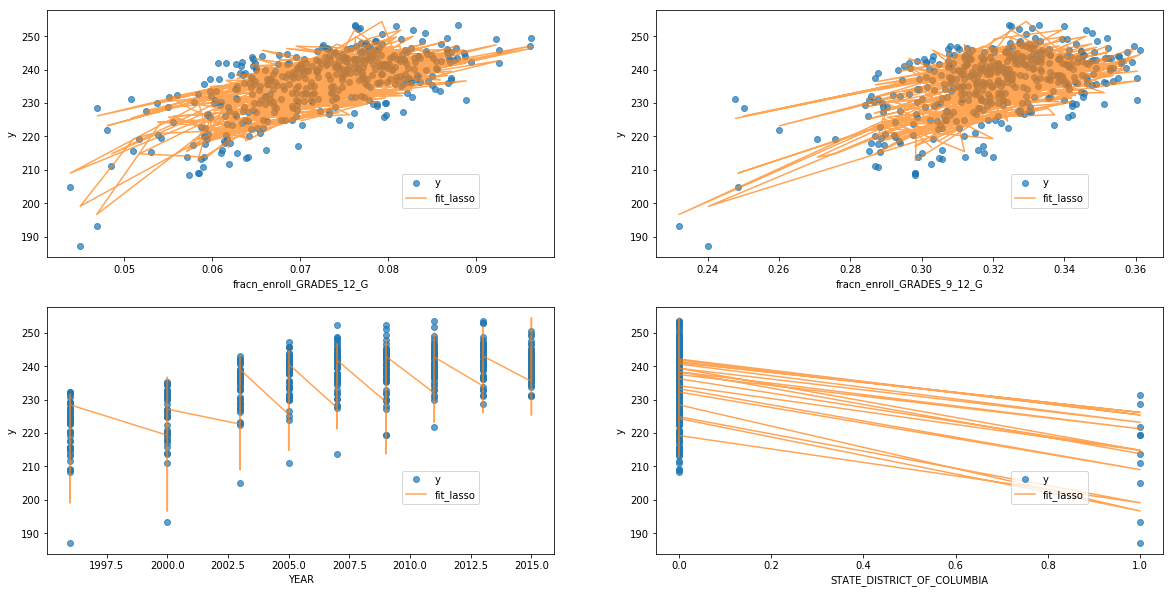

In [92]:
plt.figure(figsize=[20,10])

plt.subplot(2, 2, 1)
x1=df1.loc[:,'fracn_enroll_GRADES_12_G'].values
print(y.shape,np.shape(lasso_coef_*X),x1.shape)
plt.plot(x1,y,'o',x1,Y_lasso, alpha=0.7)
plt.legend(("y","fit_lasso"),loc=(0.7,0.2))
plt.xlabel("fracn_enroll_GRADES_12_G")
plt.ylabel("y")

plt.subplot(2, 2, 2)
x1=df1.loc[:,'fracn_enroll_GRADES_9_12_G'].values
print(y.shape,np.shape(lasso_coef_*X),x1.shape)
plt.plot(x1,y,'o',x1,Y_lasso, alpha=0.7)
plt.legend(("y","fit_lasso"),loc=(0.7,0.2))
plt.xlabel("fracn_enroll_GRADES_9_12_G")
plt.ylabel("y")

plt.subplot(2, 2, 3)
x1=df1.loc[:,'YEAR'].values
print(y.shape,np.shape(lasso_coef_*X),x1.shape)
plt.plot(x1,y,'o',x1,Y_lasso, alpha=0.7)
plt.legend(("y","fit_lasso"),loc=(0.7,0.2))
plt.xlabel("YEAR")
plt.ylabel("y")

plt.subplot(2, 2, 4)
x1=df1.loc[:,'STATE_DISTRICT_OF_COLUMBIA'].values
print(y.shape,np.shape(lasso_coef_*X),x1.shape)
plt.plot(x1,y,'o',x1,Y_lasso, alpha=0.7)
plt.legend(("y","fit_lasso"),loc=(0.7,0.2))
plt.xlabel("STATE_DISTRICT_OF_COLUMBIA")
plt.ylabel("y")

Text(0.5, 0, 'Y_lasso')

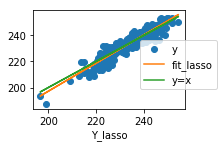

In [87]:
plt.subplot(2, 2, 1)
plt.plot(Y_lasso,y,'o',Y_lasso,line,Y_lasso,Y_lasso)
plt.legend(("y","fit_lasso","y=x"),loc=(0.7,0.2))
plt.xlabel("Y_lasso")

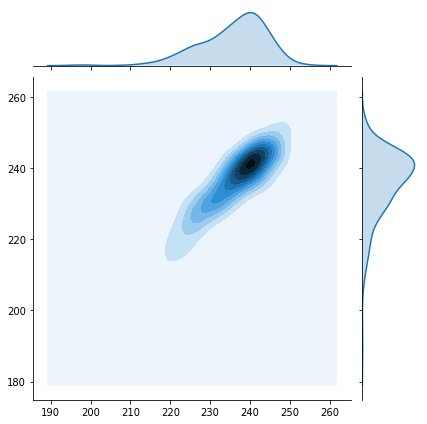

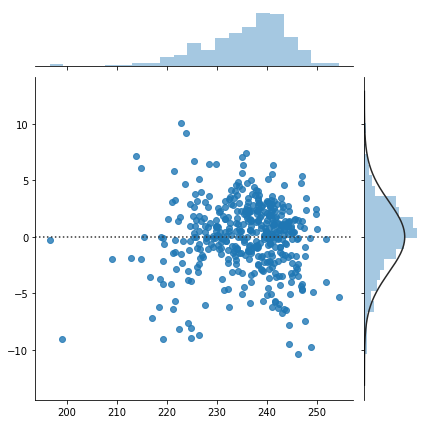

In [88]:
# Generated linear fit
slope, intercept, r_value, p_value, std_err = stats.linregress(Y_lasso,y)
line = slope*Y_lasso+intercept

#need to make analysis_df that has y,Y_lasso

#Plot
#grid=sns.JointGrid(x=Y_lasso,y=y)
#g=grid.plot_joint(sns.scatterplot) #, hue='smoker'
#sns.scatterplot(Y_lasso,line, ax=g.ax_marg_x, legend=False)
#sns.lmplot(Y_lasso,Y_lasso,ax=g.ax_marg_x,legend=False)

#plt.subplot(1,2,1)
ax1 = sns.jointplot(x=Y_lasso,y=y,kind="kde")
#plt.subplot(1,2,2)
ax2 = sns.jointplot(x=Y_lasso,y=y,kind="resid")

TypeError: 'list' object is not callable

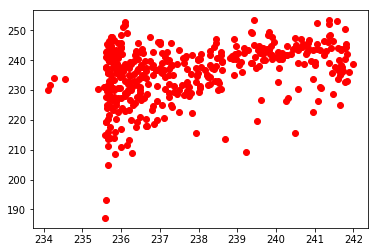

In [89]:
"""The largest coefficients are"""
X_cols[np.abs(lasso_coef_)>0.5]
""". Plot them with fits."""

plt.plot(Y_svm, y, 'ro')("YEAR", "AVG_MATH_4_SCORE", data=df, kind="reg")
sns.jointplot("YEAR", "AVG_MATH_4_SCORE", data=df, kind="reg")


In [ ]:
"""
Can I predict test scores for a year?

Handle time better. Time_series_split

Time trends: 
-Scores
-Populations
-Revenues
-Expenditures

Delta from previous time point as feature?

Features:
-Elite? financials, location, 
-Good school? school history, tax rev, district
-Trends in time? Deltas in time. more money, more students, higher scores, ...


"""